In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [4]:
tasks = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/tasks.csv')
suppliers = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/suppliers.csv')
cost = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/cost.csv.zip')
FINALdata = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/final_data.csv')

### 2.1. Use EDA methods to analyse the distribution of task features and interpret emerging patterns

We will explore if we can group Tasks based on task features and if there is a difference in terms of costs based on the group each Tasks belongs to:

In [70]:
# Create the Task dataset
task_columns = [col for col in FINALdata.columns if col.startswith("TF")] + ["Task ID"]
task_data = FINALdata[task_columns]

In [72]:
# Drop ID
task_features = task_data.drop(columns=["Task ID"])

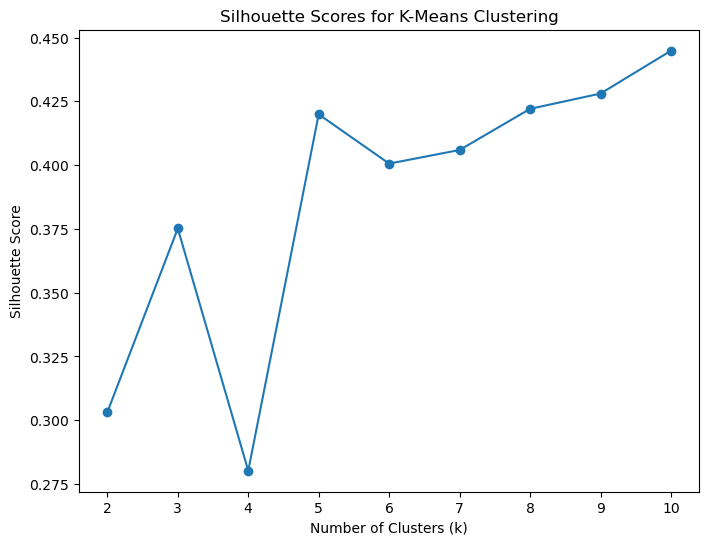

/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_12332/2253780803.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_data["Cluster"] = clusters


In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine optimal number of clusters
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(task_features)
    score = silhouette_score(task_features, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores for K-Means Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# Fit K-Means with the optimal number of clusters
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(task_features)

# Add cluster labels to the original data
task_data["Cluster"] = clusters


In [76]:
# Fit K-Means with the optimal number of clusters
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(task_features)

# Add the cluster labels to the original dataset
task_data["Cluster"] = clusters

/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_12332/1178212002.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_data["Cluster"] = clusters


In [78]:
# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
task_pca = pca.fit_transform(task_features)

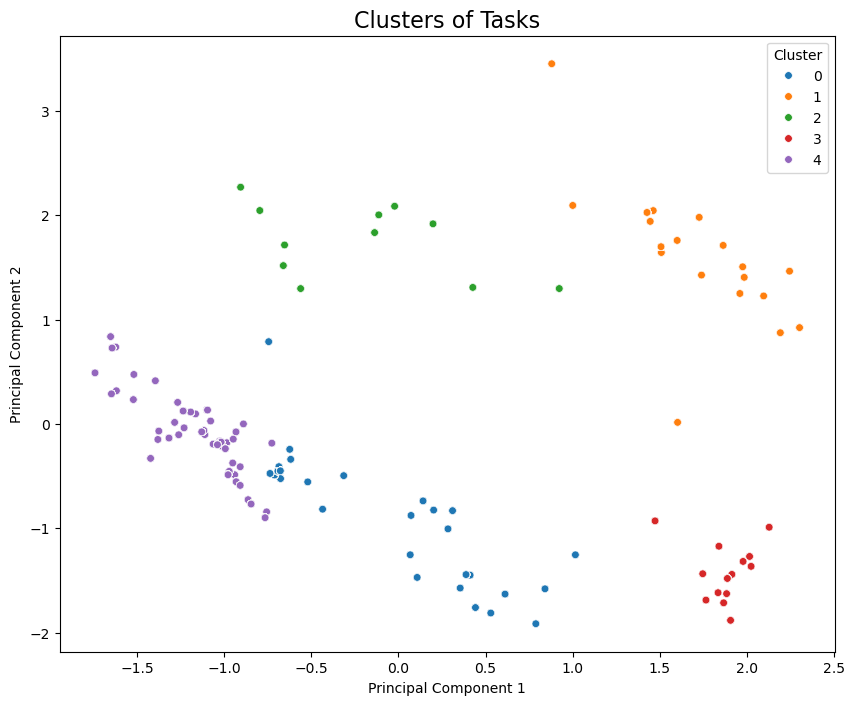

In [80]:
# Scatter plot of clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=task_pca[:, 0],
    y=task_pca[:, 1],
    hue=clusters,
    palette="tab10",
    s=30
)
plt.title("Clusters of Tasks", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")

# Save the plot as a PNG file
plt.savefig("cluster_tasks.png", format="png", dpi=300)

plt.show()


In [85]:
# Add the Cost column back to the supplier dataset
task_data.loc[:, "Cost"] = FINALdata["Cost"]

# Calculate mean, variance, and SEM
summary_cluster = task_data.groupby("Cluster")["Cost"].agg(["mean", "var", "count"]).reset_index()
summary_cluster["std_dev"] = np.sqrt(summary_cluster["var"])
summary_cluster["sem"] = summary_cluster["std_dev"] / np.sqrt(summary_cluster["count"])

z = 1.96

# Calculate confidence intervals (95% CI, Z = 1.96)
summary_cluster["ci_lower"] = summary_cluster["mean"] - z * summary_cluster["sem"]
summary_cluster["ci_upper"] = summary_cluster["mean"] + z * summary_cluster["sem"]

# Sort by mean in descending order
summary_cluster = summary_cluster.sort_values(by="mean", ascending=False)

Second cluster of tasks registers the higher average cost, while the third cluster the lowest average cost:

In [87]:
summary_cluster["Cluster"] = summary_cluster["Cluster"].astype("category")
summary_cluster.head()

,Cluster,mean,var,count,std_dev,sem,ci_lower,ci_upper
2,2,0.458956,0.001759,649,0.041943,0.001646,0.455729,0.462183
4,4,0.438622,0.001107,2832,0.033277,0.000625,0.437396,0.439847
0,0,0.418836,0.002997,1652,0.054744,0.001347,0.416196,0.421476
1,1,0.364663,0.001588,1121,0.039851,0.001190,0.362330,0.366996
3,3,0.344888,0.000416,826,0.020399,0.000710,0.343496,0.346279


We can evaluate if there is a different distribution of cost based on cluster tasks:

/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_12332/2928243062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_data["Cluster"] = task_data["Cluster"].astype("category")


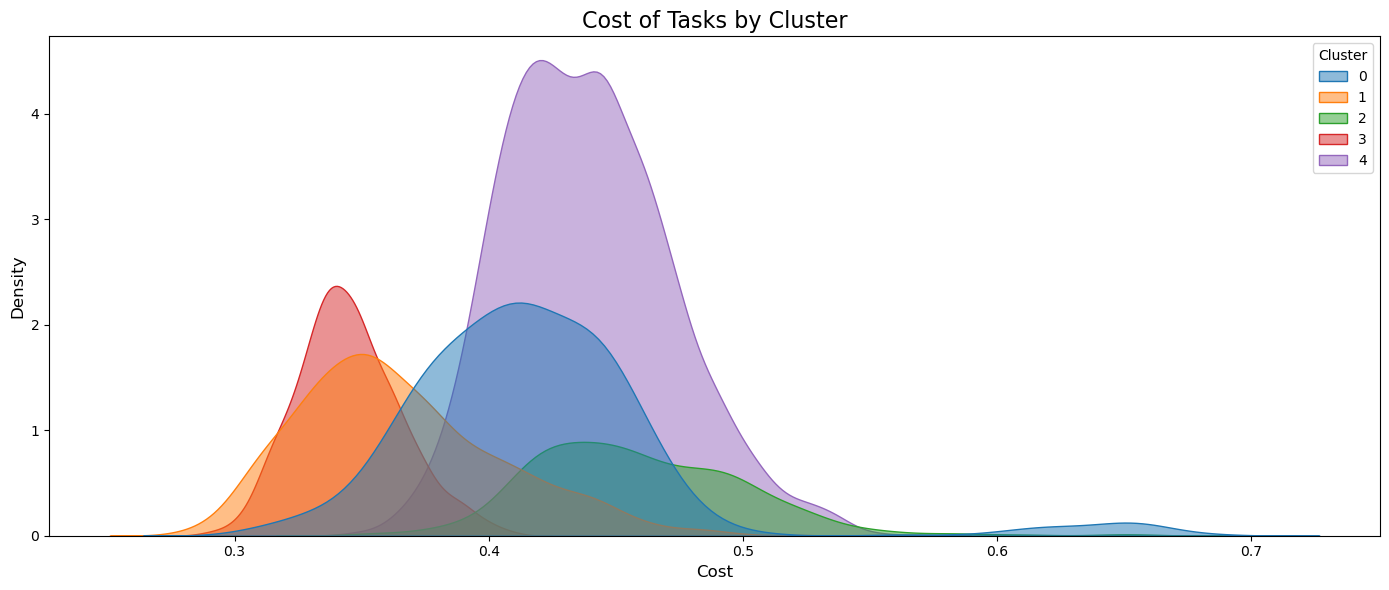

In [92]:
task_data["Cluster"] = task_data["Cluster"].astype("category")

plt.figure(figsize=(14, 6))

# Use Seaborn's kdeplot to plot densities for each cluster
sns.kdeplot(
    data=task_data,
    x="Cost",
    hue="Cluster",
    fill=True,  # Optional: adds shading under the curves
    alpha=0.5    # Transparency for better overlap visualization
)

plt.title("Cost of Tasks by Cluster", fontsize=16)
plt.xlabel("Cost", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.tight_layout()

plt.savefig("cost_cluster.png", format="png", dpi=300)

plt.show()

In [102]:
# Selecting Task Features (TF columns) using `str.startswith`
task_features = FINALdata[[col for col in FINALdata.columns if col.startswith("TF")]]

# Calculating the standard deviation for each task feature
tasks_std = task_features.std()

# Converting the results to a DataFrame for better readability
import pandas as pd
tasks_std_df = pd.DataFrame(tasks_std, columns=["Standard Deviation"])
tasks_std_df.index.name = "Task Feature"
tasks_std_df = tasks_std_df.reset_index()

# Display the result
print(tasks_std_df)


   Task Feature  Standard Deviation
0          TF71            0.810642
1           TF3            0.319474
2          TF87            0.358308
3           TF5            0.316634
4          TF52            0.297723
5          TF64            0.386074
6          TF59            0.424123
7          TF13            0.439965
8          TF25            0.469682
9          TF50            0.403478
10          TF7            0.232436
11         TF32            0.222354
12         TF33            0.329384
13         TF82            0.539229
14         TF73            0.359976
15         TF17            0.441538
16         TF21            0.444621
17          TF9            0.479032
18         TF23            0.280886
19        TF115            0.406471
20         TF16            0.439328
21        TF114            0.395175
22         TF67            0.389308
23         TF27            0.339576
24         TF38            0.429527
25         TF18            0.499777
26         TF37            0

/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_12332/2751518171.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


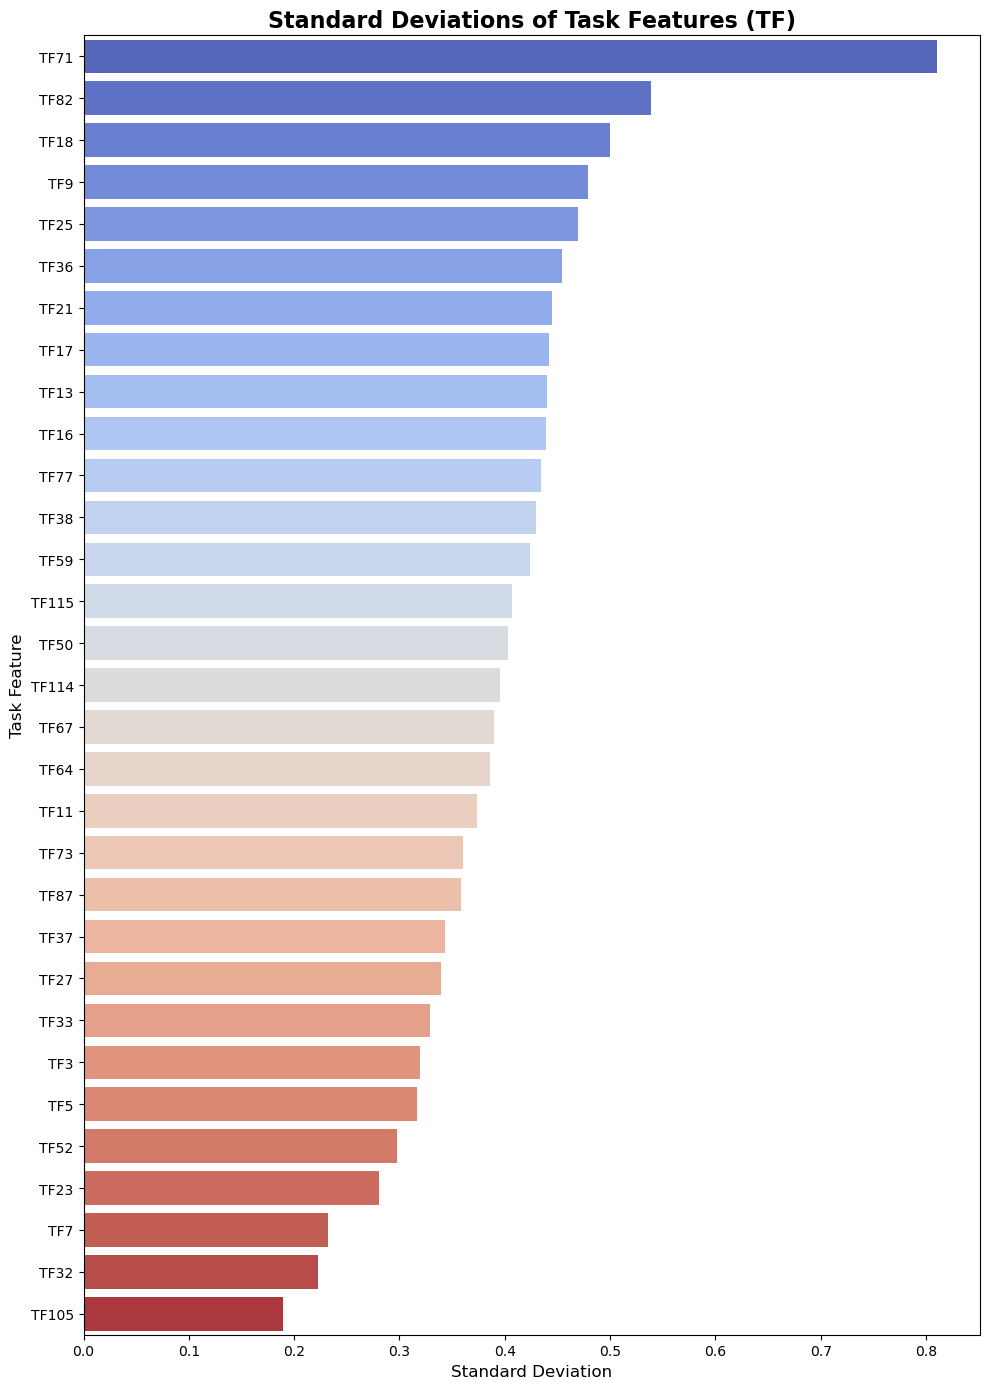

In [104]:
plt.figure(figsize=(10, 14))
sns.barplot(
    y="Task Feature", 
    x="Standard Deviation", 
    data=tasks_std_df.sort_values(by="Standard Deviation", ascending=False), 
    palette="coolwarm"
)

# Adding labels and title
plt.title("Standard Deviations of Task Features (TF)", fontsize=16, fontweight="bold")
plt.xlabel("Standard Deviation", fontsize=12)
plt.ylabel("Task Feature", fontsize=12)

# Adjusting layout and show the plot
plt.tight_layout()
plt.show()


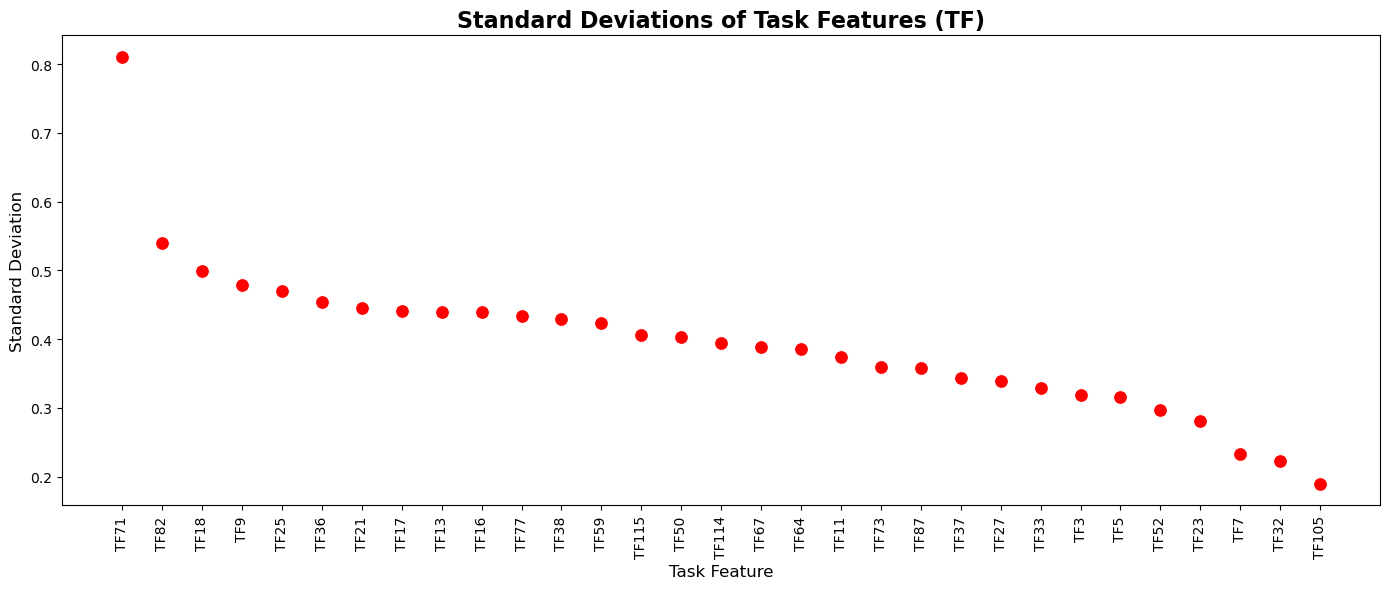

In [106]:
# Plotting standard deviations of Task Features

plt.figure(figsize=(14, 6))
sns.scatterplot(
    x="Task Feature", 
    y="Standard Deviation", 
    data=tasks_std_df.sort_values(by="Standard Deviation", ascending=False), 
    s=100, 
    color="red"
)

# Add labels and title
plt.title("Standard Deviations of Task Features (TF)", fontsize=16, fontweight="bold")
plt.xlabel("Task Feature", fontsize=12)
plt.ylabel("Standard Deviation", fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Number of TF features: 31


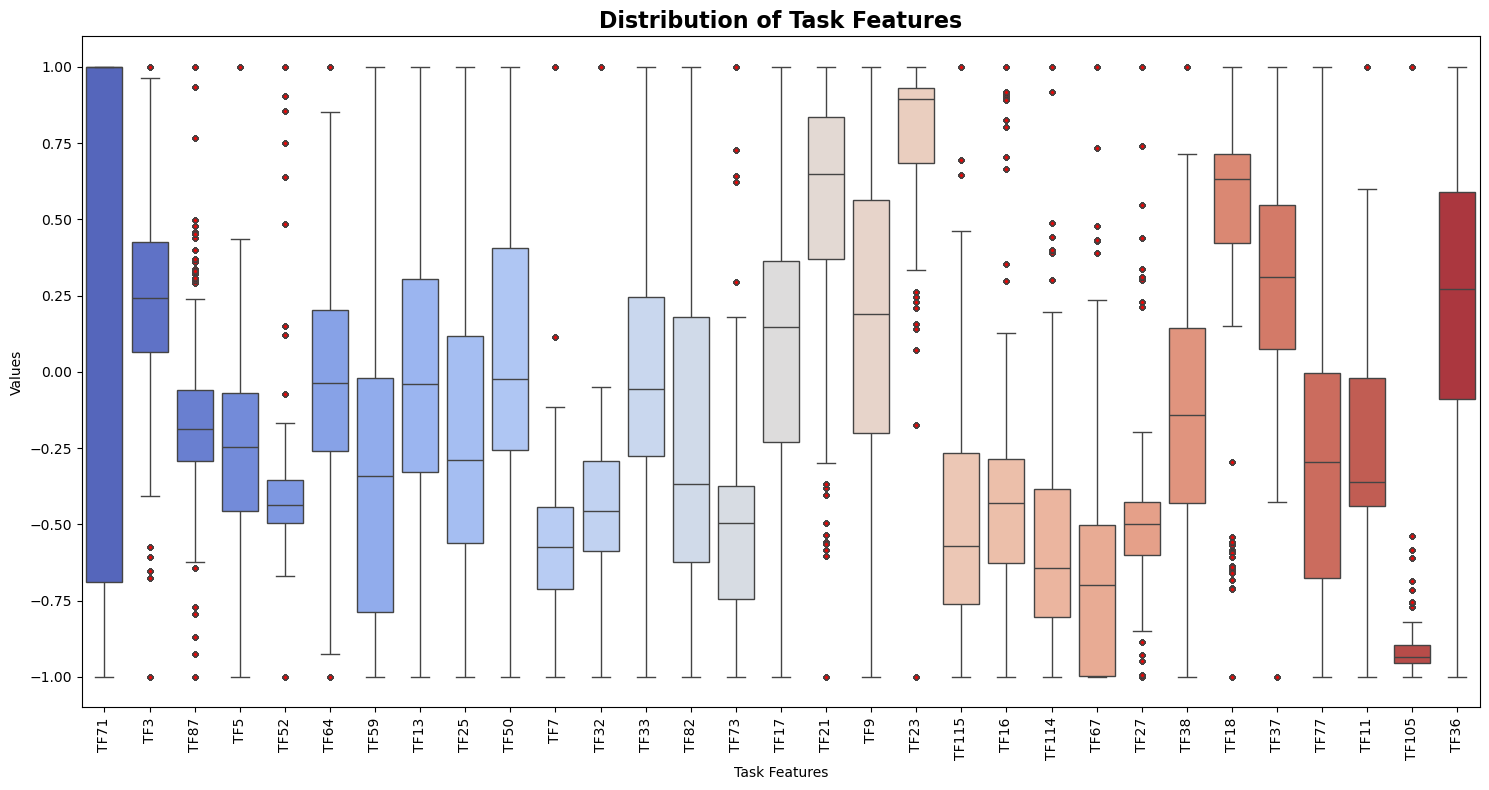

In [108]:
# Selecting Task Features (TF columns) using str.startswith
task_features = FINALdata[[col for col in FINALdata.columns if col.startswith("TF")]]

# Counting the number of TF features
num_tf_features = len(task_features.columns)
print(f"Number of TF features: {num_tf_features}")

# Plotting the distribution of task features
plt.figure(figsize=(15, 8))
flierprops = dict(marker='o', markersize=3, linestyle='none', markerfacecolor='red', alpha=0.6)  # Customising outliers
boxplot = sns.boxplot(data=task_features, flierprops=flierprops, palette="coolwarm")

# Customising plot labels and title
boxplot.set(xlabel='Task Features', ylabel='Values')
boxplot.axes.set_title('Distribution of Task Features', fontsize=16, fontweight='bold')

# Adjusting x-ticks for better readability
boxplot.set_xticks(range(len(task_features.columns)))
boxplot.set_xticklabels(task_features.columns, rotation=90, fontsize=10)

# Ensuring the layout is tight
plt.tight_layout()

# Show the plot
plt.show()

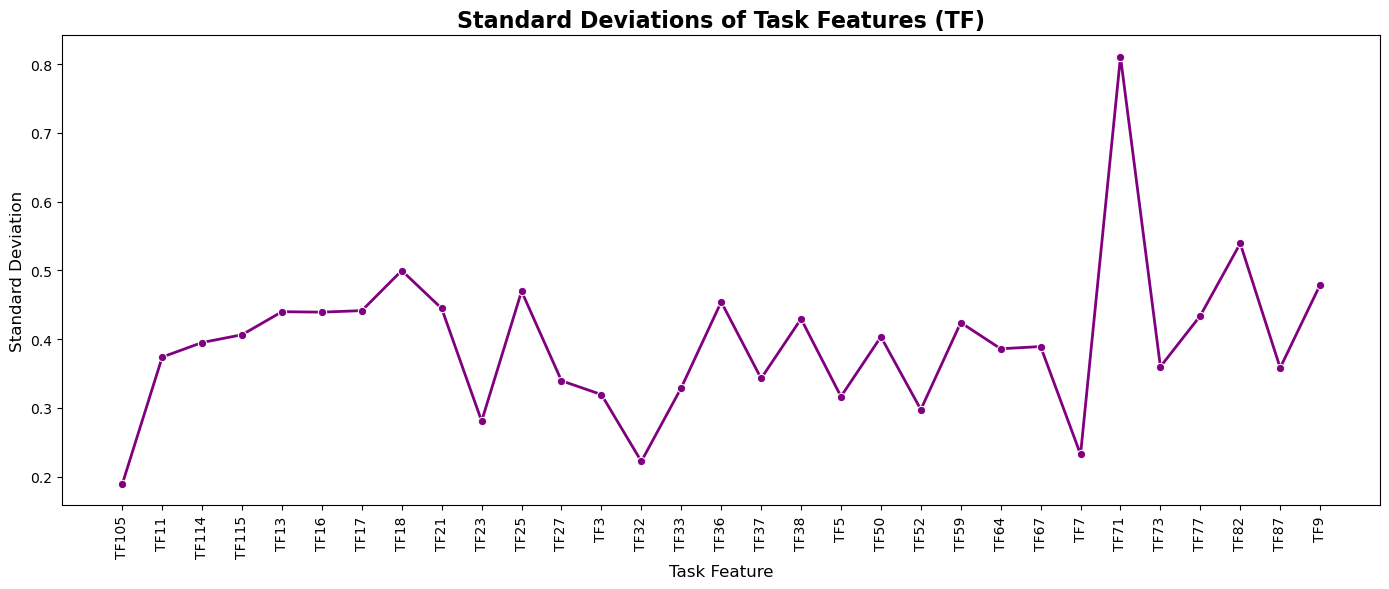

In [110]:
plt.figure(figsize=(14, 6))
sns.lineplot(
    x="Task Feature", 
    y="Standard Deviation", 
    data=tasks_std_df.sort_values(by="Task Feature"), 
    marker="o", 
    linewidth=2, 
    color="purple"
)

# Add labels and title
plt.title("Standard Deviations of Task Features (TF)", fontsize=16, fontweight="bold")
plt.xlabel("Task Feature", fontsize=12)
plt.ylabel("Standard Deviation", fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


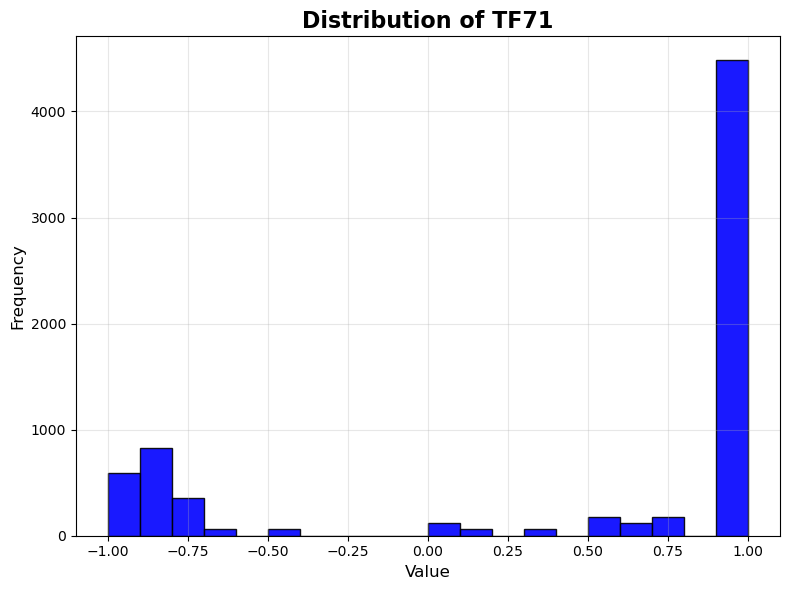

In [112]:
# Histogram for TF71 (The most important feature according to the Random Forest)
plt.figure(figsize=(8, 6))
plt.hist(task_features['TF71'], bins=20, color='blue', alpha=0.9, edgecolor='black')
plt.title("Distribution of TF71", fontsize=16, fontweight='bold')
plt.xlabel("Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)  # Make gridlines more visible
plt.tight_layout()
plt.show()


/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_12332/3418530895.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(combined_data["Task Feature"], rotation=90, fontsize=10)


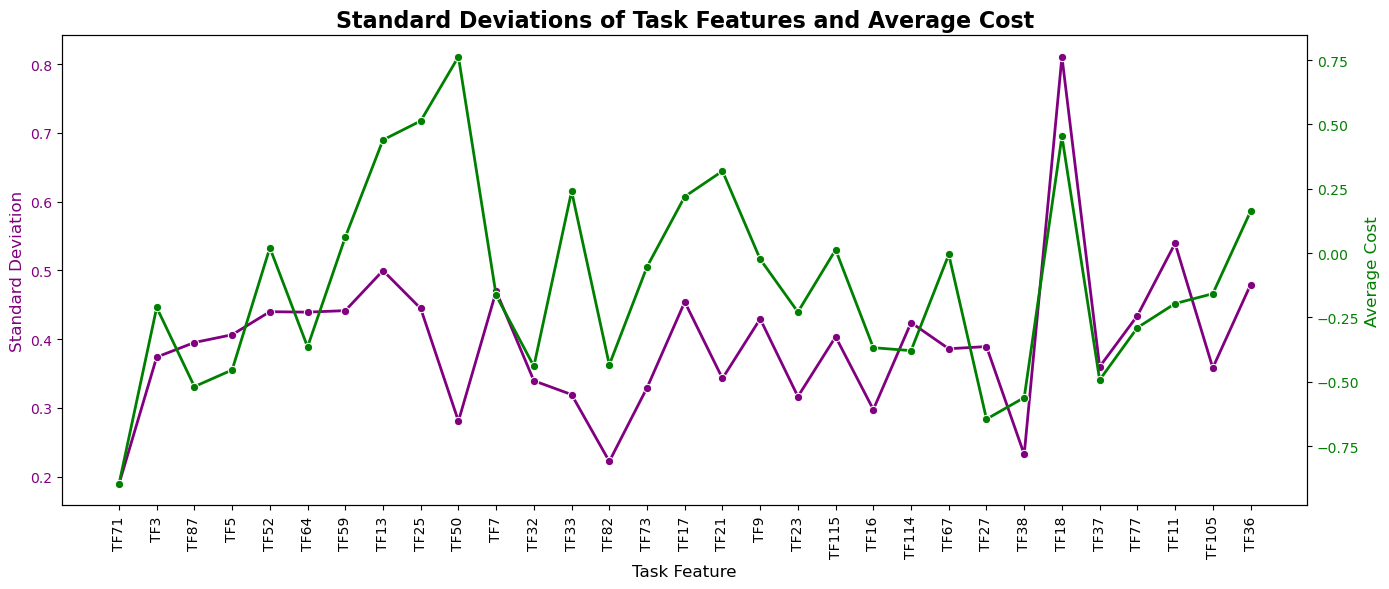

In [114]:

# Calculate the average cost per task feature (TF)
avg_cost_per_task = FINALdata[[col for col in FINALdata.columns if col.startswith("TF")]].mean()

# Create a DataFrame combining Standard Deviations and Average Costs
combined_data = pd.DataFrame({
    "Task Feature": tasks_std_df["Task Feature"],
    "Standard Deviation": tasks_std_df["Standard Deviation"],
    "Average Cost": avg_cost_per_task.values
})

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Standard Deviation on the left axis
sns.lineplot(
    x="Task Feature", 
    y="Standard Deviation", 
    data=combined_data.sort_values(by="Task Feature"), 
    marker="o", 
    linewidth=2, 
    color="purple", 
    ax=ax1
)

ax1.set_title("Standard Deviations of Task Features and Average Cost", fontsize=16, fontweight="bold")
ax1.set_xlabel("Task Feature", fontsize=12)
ax1.set_ylabel("Standard Deviation", fontsize=12, color="purple")
ax1.tick_params(axis="y", labelcolor="purple")
ax1.set_xticklabels(combined_data["Task Feature"], rotation=90, fontsize=10)

# Create a second y-axis to plot Average Cost
ax2 = ax1.twinx()
sns.lineplot(
    x="Task Feature", 
    y="Average Cost", 
    data=combined_data.sort_values(by="Task Feature"), 
    marker="o", 
    linewidth=2, 
    color="green", 
    ax=ax2
)

# Add labels for the second axis
ax2.set_ylabel("Average Cost", fontsize=12, color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Adjust layout to ensure nothing is cut off
plt.tight_layout()
plt.show()


### 2.2. Analyse the cost data to identify patterns and good combinations of tasks and suppliers.

General distribution of cost:

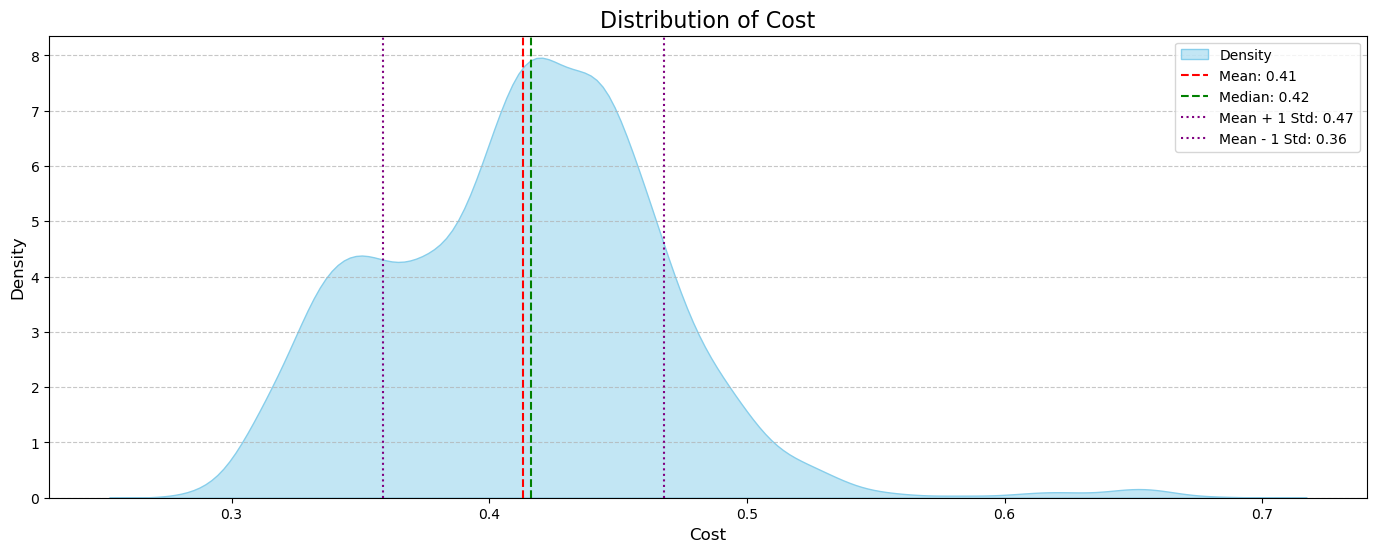

In [157]:
# Calculate descriptive statistics
mean_cost = FINALdata["Cost"].mean()
std_cost = FINALdata["Cost"].std()
median_cost = FINALdata["Cost"].median()

# Density plot for the 'Cost' variable
plt.figure(figsize=(17, 6))
sns.kdeplot(data=FINALdata, x="Cost", fill=True, color="skyblue", alpha=0.5, label="Density")

# Add lines for mean, std, and median
plt.axvline(mean_cost, color="red", linestyle="--", label=f"Mean: {mean_cost:.2f}")
plt.axvline(median_cost, color="green", linestyle="--", label=f"Median: {median_cost:.2f}")
plt.axvline(mean_cost + std_cost, color="purple", linestyle=":", label=f"Mean + 1 Std: {mean_cost + std_cost:.2f}")
plt.axvline(mean_cost - std_cost, color="purple", linestyle=":", label=f"Mean - 1 Std: {mean_cost - std_cost:.2f}")

# Add plot labels and legend
plt.title("Distribution of Cost", fontsize=16)
plt.xlabel("Cost", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot as a PNG file
plt.savefig("cost_distribution.png", format="png", dpi=300)

plt.show()

Now we will analyze the performance of suppliers in relation to the cost of each task they are assigned:

In [116]:
summary = cost.groupby("Supplier ID")["Cost"].agg(["mean", "var", "count"]).reset_index()
summary.head()

,Supplier ID,mean,var,count
0,S1,0.443069,0.003239,120
1,S10,0.403872,0.003431,120
2,S11,0.401271,0.002745,120
3,S12,0.415246,0.003090,120
4,S13,0.407144,0.003045,120


In [118]:
# Calculate mean, variance, and SEM
summary = cost.groupby("Supplier ID")["Cost"].agg(["mean", "var", "count"]).reset_index()
summary["std_dev"] = np.sqrt(summary["var"])
summary["sem"] = summary["std_dev"] / np.sqrt(summary["count"])

# Calculate confidence intervals (95% CI, Z = 1.96)
z = 1.96
summary["ci_lower"] = summary["mean"] - z * summary["sem"]
summary["ci_upper"] = summary["mean"] + z * summary["sem"]

# Sort by mean in descending order
summary = summary.sort_values(by="mean", ascending=False).reset_index(drop=True)

We show the suppliers that will be deleted due to bad performance:

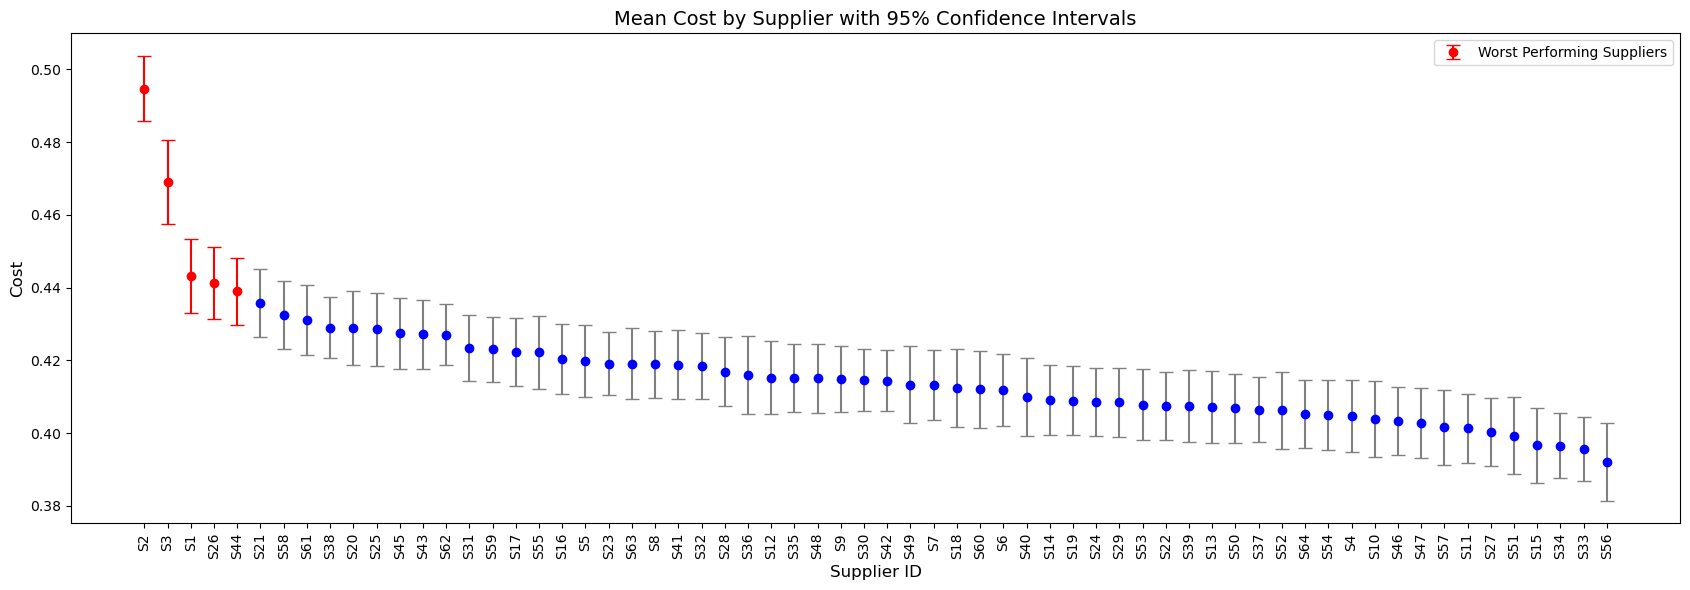

In [120]:
# Suppliers to highlight
highlight_suppliers = {"S2", "S3", "S1", "S26", "S44"}

# Define colors based on condition
colors = ["red" if supplier in highlight_suppliers else "blue" for supplier in summary["Supplier ID"]]

# Plot
plt.figure(figsize=(17, 6))
for i, supplier in enumerate(summary["Supplier ID"]):
    plt.errorbar(
        supplier,
        summary["mean"][i],
        yerr=z * summary["sem"][i],
        fmt='o',
        capsize=5,
        color=colors[i],  # Use dynamic color
        ecolor='gray' if colors[i] == "blue" else "red",  # Highlight CI in red
        label="Highlighted" if colors[i] == "red" and i == 0 else None
    )

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add titles and labels
plt.title("Mean Cost by Supplier with 95% Confidence Intervals", fontsize=14)
plt.xlabel("Supplier ID", fontsize=12)
plt.ylabel("Cost", fontsize=12)
plt.legend(["Worst Performing Suppliers"], loc="upper right")

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("error_bars_highlighted.png", format="png", dpi=300)

plt.show()

In [124]:
# Calculate mean, variance, and SEM
summary2 = FINALdata.groupby("Supplier ID")["Cost"].agg(["mean", "var", "count"]).reset_index()
summary2["std_dev"] = np.sqrt(summary2["var"])
summary2["sem"] = summary2["std_dev"] / np.sqrt(summary2["count"])

# Calculate confidence intervals (95% CI, Z = 1.96)
z = 1.96
summary2["ci_lower"] = summary2["mean"] - z * summary2["sem"]
summary2["ci_upper"] = summary2["mean"] + z * summary2["sem"]

# Sort by mean in descending order
summary2 = summary2.sort_values(by="mean", ascending=False).reset_index(drop=True)

This is the final distribution of supplier performance (after dropping worst performing suppliers):

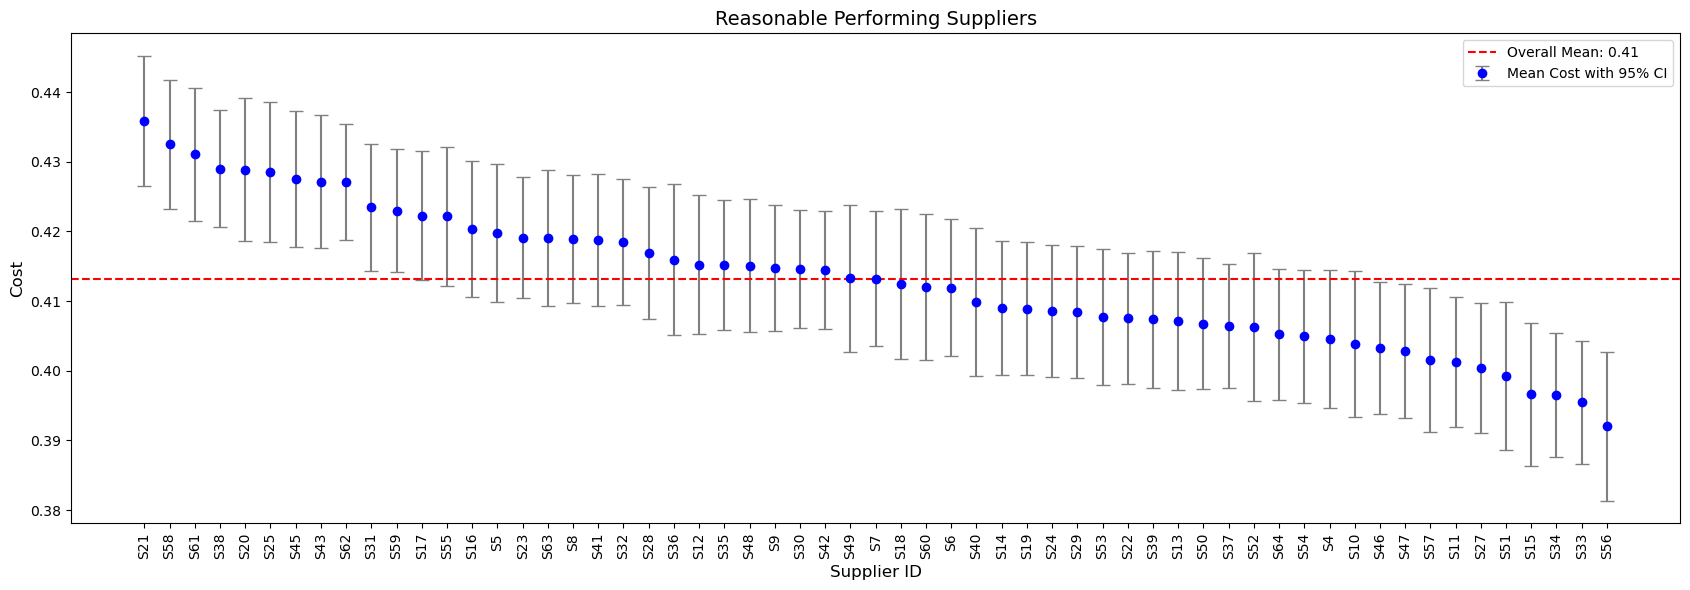

In [159]:
# Calculate the overall mean
overall_mean = summary2["mean"].mean()

# Plot
plt.figure(figsize=(17, 6))
plt.errorbar(
    summary2["Supplier ID"],
    summary2["mean"],
    yerr=z * summary2["sem"],
    fmt='o',
    capsize=5,
    color='blue',
    ecolor='gray',
    label="Mean Cost with 95% CI"
)

# Add a horizontal line for the overall mean
plt.axhline(y=overall_mean, color='red', linestyle='--', label=f"Overall Mean: {overall_mean:.2f}")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add titles and labels
plt.title("Reasonable Performing Suppliers", fontsize=14)
plt.xlabel("Supplier ID", fontsize=12)
plt.ylabel("Cost", fontsize=12)
plt.legend()

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("error_bars_suppliers2.png", format="png", dpi=300)

plt.show()


/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_12332/2311838118.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Supplier ID", y="Cost", data=FINALdata, palette="coolwarm")


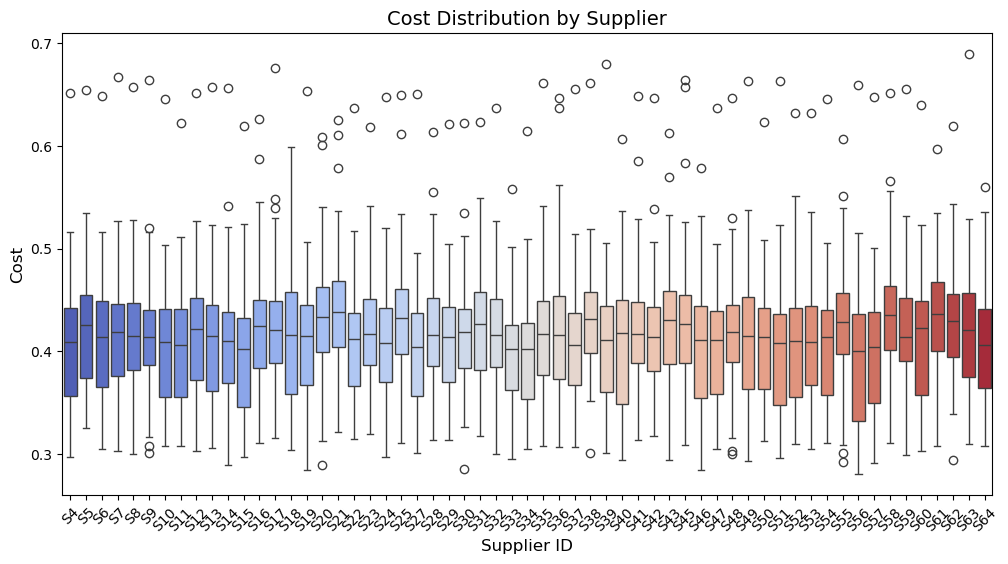

In [169]:
# Boxplot for Cost Distribution by Supplier
plt.figure(figsize=(12, 6))
sns.boxplot(x="Supplier ID", y="Cost", data=FINALdata, palette="coolwarm")
plt.title("Cost Distribution by Supplier", fontsize=14)
plt.xlabel("Supplier ID", fontsize=12)
plt.ylabel("Cost", fontsize=12)
plt.xticks(rotation=45)
plt.show()

Now the good combinations between tasks and suppliers based on cost:

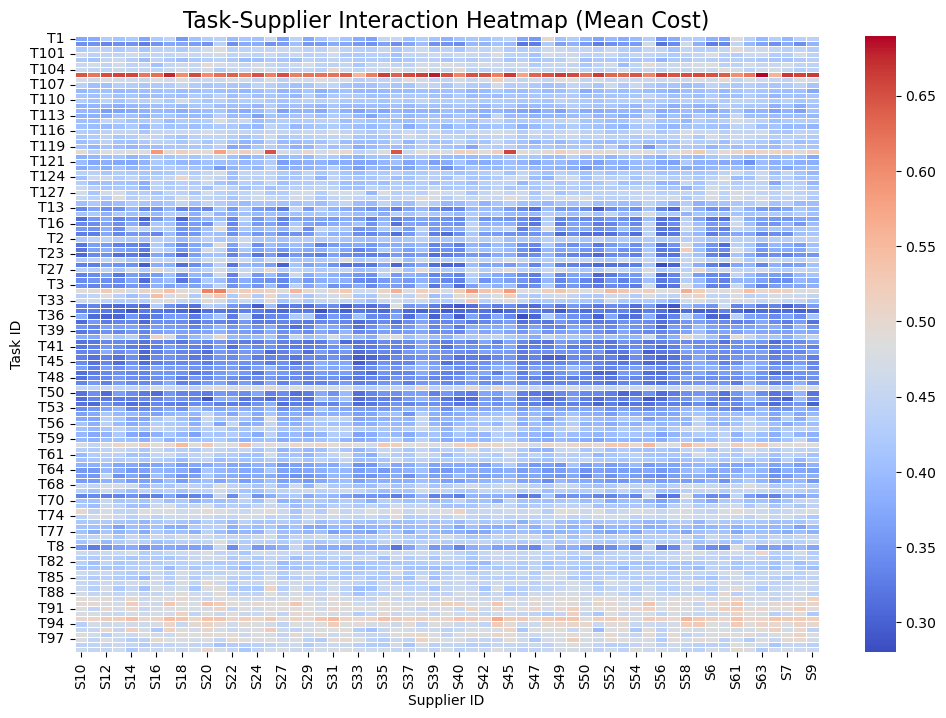

In [132]:
# Creating a pivot table of mean costs for each Task and Supplier combination
tasksupplierheatmap = FINALdata.pivot_table(
    index='Task ID', columns='Supplier ID', values='Cost', aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(tasksupplierheatmap, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Task-Supplier Interaction Heatmap (Mean Cost)", fontsize=16)
plt.xlabel("Supplier ID")
plt.ylabel("Task ID")

plt.savefig("heatmap.png", format="png", dpi=300)

plt.show()


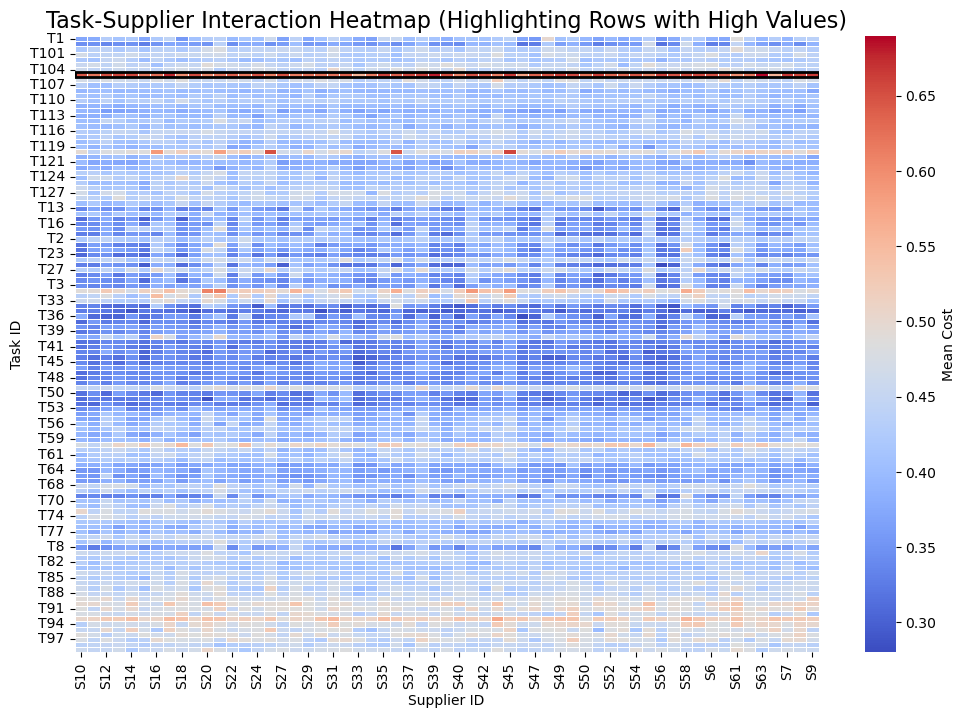

In [134]:
import matplotlib.patches as patches

# Identify rows where all suppliers have high values
highlight_rows = tasksupplierheatmap[tasksupplierheatmap.min(axis=1) > 0.5].index

# Plot the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    tasksupplierheatmap, 
    cmap='coolwarm', 
    annot=False, 
    linewidths=0.5, 
    cbar_kws={'label': 'Mean Cost'}
)
plt.title("Task-Supplier Interaction Heatmap (Highlighting Rows with High Values)", fontsize=16)
plt.xlabel("Supplier ID")
plt.ylabel("Task ID")

# Add rectangles to highlight rows
for row in highlight_rows:
    row_idx = list(tasksupplierheatmap.index).index(row)
    rect = patches.Rectangle(
        (0, row_idx),  # Bottom-left corner of the rectangle
        tasksupplierheatmap.shape[1],  # Width (number of suppliers)
        1,  # Height
        linewidth=2, 
        edgecolor='black', 
        facecolor='none'
    )
    ax.add_patch(rect)

plt.show()


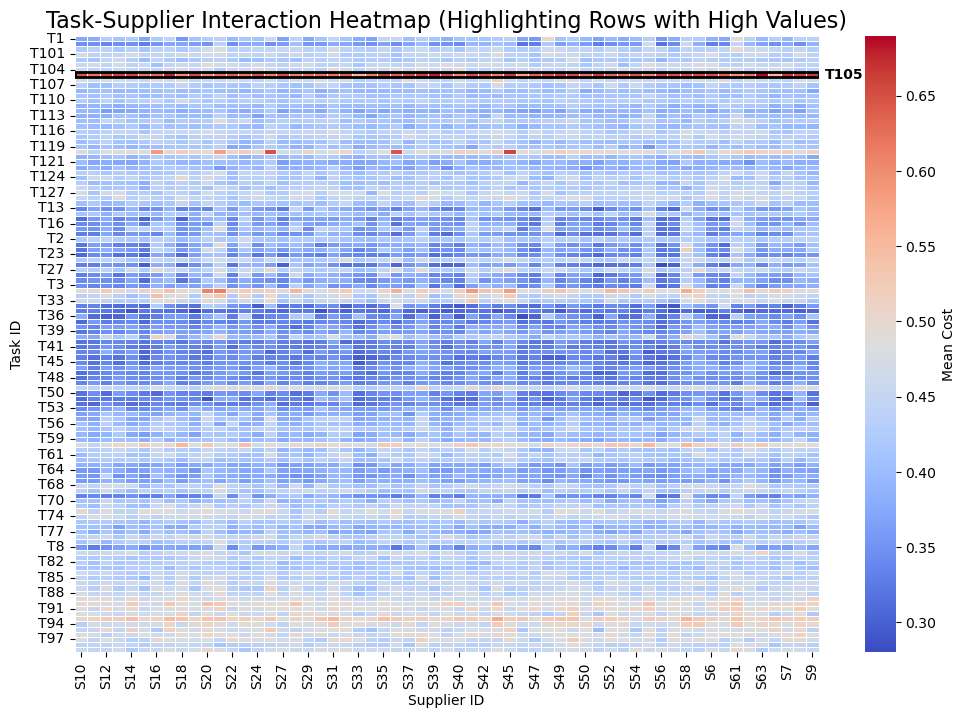

In [136]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    tasksupplierheatmap, 
    cmap='coolwarm', 
    annot=False, 
    linewidths=0.5, 
    cbar_kws={'label': 'Mean Cost'}
)
plt.title("Task-Supplier Interaction Heatmap (Highlighting Rows with High Values)", fontsize=16)
plt.xlabel("Supplier ID")
plt.ylabel("Task ID")

# Adding rectangles and annotating task numbers on the right-hand side
for row in highlight_rows:
    row_idx = list(tasksupplierheatmap.index).index(row)
    # Add rectangle to highlight the row
    rect = patches.Rectangle(
        (0, row_idx),  # Bottom-left corner of the rectangle
        tasksupplierheatmap.shape[1],  # Width (number of suppliers)
        1,  # Height
        linewidth=2, 
        edgecolor='black', 
        facecolor='none'
    )
    ax.add_patch(rect)
    # Annotating the task number on the right-hand side
    plt.text(
        tasksupplierheatmap.shape[1] + 0.5,  # X-coordinate outside the heatmap
        row_idx + 0.5,  # Y-coordinate at the center of the row
        f"{row}",  # Annotation text (Task ID)
        fontsize=10,
        fontweight='bold',
        color='black',
        va='center',  # Vertically align to the center
        ha='left'  # Horizontally align to the left
    )

plt.show()
